# Iceland Snow and Ice Monitoring

This notebook implements a workflow for monitoring snow and ice in Iceland using Sentinel-2 data via the EOPF Zarr format.

---

## DISCLAIMER: Known Issues

**The native-like Alogrithm currently does not execute successfully due to memory constraints.**

- The Sentinel-2 scenes from the EOPF Zarr store are extremely large (full scene extents)
- Even loading a single scene causes JupyterHub to crash due to insufficient memory
- The native-like workflow approach (loading full scenes instead of tiles) is not feasible in resource-constrained environments
---

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from shapely.geometry import box
import shapely.geometry
import pystac_client
from pystac import Item
import xarray as xr
import os
import requests
from datetime import datetime
from pyproj import Transformer
import dask
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed

## Seeds
Load the glacier seeds (points) and define the Area of Interest.

In [2]:
# Load seeds
seeds_gdf = gpd.read_file("data/Iceland_Seeds.geojson")

# Reproject to WGS84 for search
seeds_gdf = seeds_gdf.to_crs("EPSG:4326")

# Get bounding box in WGS84
total_bounds = seeds_gdf.total_bounds
bbox_4326 = list(total_bounds) # [minx, miny, maxx, maxy]

# Define AOI for UTM transformation
spatial_extent = {
    "west": bbox_4326[0],
    "south": bbox_4326[1],
    "east": bbox_4326[2],
    "north": bbox_4326[3],
}

print(f"Bbox (EPSG:4326): {bbox_4326}")

# Convert AOI to UTM 27N (EPSG:32627) - Common for Iceland
# The example used EPSG:32631 for Belgium. For Iceland, we use 32627.
target_crs = "EPSG:32627"
transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)

west_utm, south_utm = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east_utm, north_utm = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

# Spatial slice parameters (Note: y is typically north-to-south in these grids, so slice order matters)
# We will verify the order after inspection, but typically it is slice(max_y, min_y) or slice(min_y, max_y) depending on the index.
# The example used slice(north_utm, south_utm) for y, implying descending coordinates.
x_slice = slice(west_utm, east_utm)
y_slice = slice(north_utm, south_utm)

print(f"UTM Bounds ({target_crs}): West={west_utm}, South={south_utm}, East={east_utm}, North={north_utm}")

Bbox (EPSG:4326): [np.float64(-23.77593305479282), np.float64(63.644977182030495), np.float64(-13.940908081882865), np.float64(66.20015537924486)]
UTM Bounds (EPSG:32627): West=362535.61403618613, South=7060438.683328982, East=817331.8137813979, North=7360136.248818787


## STAC Search and Data Loading

This section connects to the EOPF STAC catalog and searches for Sentinel-2 L2A scenes within a specified time range and bounding box.

**What this code does:**
- Opens a connection to the EOPF STAC catalog (`stac.core.eopf.eodc.eu`)
- Searches for Sentinel-2 Level-2A products within the defined time range and AOI
- Filters out deprecated items and extracts product URLs (hrefs)
- In `SINGLE_SCENE_MODE`, selects a specific scene for testing

**Algorithm approach:**
This algorithm simulates a **file-based workflow** by processing full Sentinel-2 scenes retrieved from the EOPF Zarr store. It avoids tile-based optimization and instead loads the full scene extent to compute NDSI and classify snow.

> **Warning:** This approach is memory-intensive. Loading full scenes may exceed available RAM.

In [3]:
# === Configuration ===
SINGLE_SCENE_MODE = True  # Toggle: True = specific scene, False = all scenes
SINGLE_SCENE_NAME = "S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr"
    
# STAC Search
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Search for Sentinel-2 L2A items
time_range_str = "2025-07-01/2025-07-31"

print(f"Searching STAC for {time_range_str} over AOI...")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox_4326,
    datetime=time_range_str,
)

items = list(search.items())
print(f"Found {len(items)} items.")

# Filter: only non-deprecated items with 'product' asset
valid_items = [
    item for item in items 
    if not item.properties.get("deprecated", False) and "product" in item.assets
]
print(f"Valid items with product asset: {len(valid_items)}")

# Get hrefs for file-based processing
hrefs = [item.assets["product"].href for item in valid_items]

# Apply single scene toggle
if SINGLE_SCENE_MODE:
    # Find the specific scene
    matching = [h for h in hrefs if SINGLE_SCENE_NAME in h]
    if matching:
        hrefs = [matching[0]]
        print(f"\n[SINGLE_SCENE_MODE] Using specific scene: {SINGLE_SCENE_NAME}")
    elif hrefs:
        hrefs = [hrefs[0]]
        print(f"\n[SINGLE_SCENE_MODE] Specific scene not found, using first: {os.path.basename(hrefs[0])}")
elif hrefs:
    print(f"\nTotal scenes to process: {len(hrefs)}")

Searching STAC for 2025-07-01/2025-07-31 over AOI...
Found 107 items.
Valid items with product asset: 107

[SINGLE_SCENE_MODE] Using specific scene: S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr


## Native-Like Scene Processing

### What is a "Native-Like" Workflow?

In traditional satellite image processing, scientists download entire image files to their computer and process them locally. This is how algorithms were originally designed before cloud computing existed.

**This notebook simulates that traditional approach:**
- We treat each Sentinel-2 scene as a complete "file" 
- We load the full scene into memory
- We process it entirely before moving to the next scene

This is in contrast to modern **tile-based** approaches where only small chunks of data are loaded as needed.

### What happens in this section?

1. **Load a scene** → Download the satellite image bands we need (Green and SWIR channels)
2. **Calculate snow index** → Apply the NDSI formula to identify snow/ice pixels
3. **Create a mask** → Mark which pixels are snow and which are not

### Why doesn't it work?

The Sentinel-2 scenes from the EOPF store are very large (hundreds of MB to GB per scene). When we try to load an entire scene into memory at once, JupyterHub runs out of RAM and crashes, even with just one scene.

> **Bottom line:** This approach demonstrates the algorithm logic, but cannot actually run in resource-limited environments like our JupyterHub.

In [4]:
def load_scene(href, x_slice, y_slice, use_full_scene=True):
    """
    Load a single Sentinel-2 scene from EOPF Zarr store.
    Returns bands B03 (Green), B11 (SWIR), and SCL mask aligned to 10m grid.
    
    Parameters:
    -----------
    href : str
        Path to the Zarr store
    x_slice, y_slice : slice
        AOI bounds (used for scene selection, not clipping if use_full_scene=True)
    use_full_scene : bool
        If True, loads the entire scene extent instead of clipping to AOI.
        This ensures scenes at AOI boundaries are fully processed.
    """
    scene_name = os.path.basename(href.rstrip("/"))
    print(f"Loading scene: {scene_name}")
    
    # Load Green Band (B03) - 10m resolution
    ds_b03_full = xr.open_zarr(href, group="/measurements/reflectance/r10m")[["b03"]]
    
    if use_full_scene:
        # Use full scene extent - no clipping
        ds_b03 = ds_b03_full
        print(f"  → Using full scene extent")
    else:
        # Clip to AOI
        ds_b03 = ds_b03_full.sel(x=x_slice, y=y_slice)
    
    # Load SWIR Band (B11) - 20m resolution
    ds_b11_full = xr.open_zarr(href, group="/measurements/reflectance/r20m")[["b11"]]
    
    if use_full_scene:
        ds_b11 = ds_b11_full
    else:
        ds_b11 = ds_b11_full.sel(x=x_slice, y=y_slice)
    
    # Load SCL (Scene Classification) - 20m resolution
    ds_scl_full = xr.open_zarr(href, group="/conditions/mask/l2a_classification/r20m")[["scl"]]
    
    if use_full_scene:
        ds_scl = ds_scl_full
    else:
        ds_scl = ds_scl_full.sel(x=x_slice, y=y_slice)
    
    # Resample 20m bands to 10m grid
    ds_b11_interp = ds_b11.interp_like(ds_b03, method="nearest")
    ds_scl_interp = ds_scl.interp_like(ds_b03, method="nearest")
    
    # Merge into single dataset
    scene_data = xr.merge([ds_b03, ds_b11_interp, ds_scl_interp])
    
    # Extract datetime from filename
    parts = scene_name.split("_")
    date_str = next((p for p in parts if p.startswith("20") and "T" in p), None)
    if date_str:
        scene_data.attrs["datetime"] = datetime.strptime(date_str.split(".")[0], "%Y%m%dT%H%M%S")
    
    scene_data.attrs["scene_name"] = scene_name
    return scene_data


def compute_ndsi(scene_data):
    """
    Compute NDSI (Normalized Difference Snow Index) and snow mask.
    NDSI = (Green - SWIR) / (Green + SWIR)
    Snow threshold: NDSI > 0.42
    """
    green = scene_data["b03"]
    swir = scene_data["b11"]
    scl = scene_data["scl"]
    
    # Calculate NDSI
    denom = green + swir
    ndsi = (green - swir) / denom.where(denom != 0)
    
    # Mask: exclude Nodata (0), Saturated (1), Cloud Shadows (3)[it can see snow even if there are cloud shadows], Water (6), Unclassified (7), Cloud Medium (8), Cloud High (9)
    valid_mask = ~scl.isin([0,1,6,7,8,9])
    
    # Snow classification (NDSI > 0.42 and valid pixel)
    snow_mask = (ndsi > 0.42) & valid_mask
    
    return xr.Dataset({
        "ndsi": ndsi,
        "snow_mask": snow_mask,
        "valid_mask": valid_mask,
    }, attrs=scene_data.attrs)


def process_scenes(hrefs, x_slice, y_slice, use_full_scene=True):
    """
    Process all scenes in file-based workflow.
    Returns list of results (one per scene).
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, processes entire scene extent instead of clipping to AOI.
    """
    results = []
    
    for i, href in enumerate(hrefs):
        print(f"\n[{i+1}/{len(hrefs)}] Processing...")
        try:
            # Load scene
            scene_data = load_scene(href, x_slice, y_slice, use_full_scene=use_full_scene)
            
            # Compute NDSI and snow mask
            result = compute_ndsi(scene_data)
            
            # Trigger computation
            result = result.compute()
            
            # Statistics
            snow_pixels = result["snow_mask"].sum().item()
            valid_pixels = result["valid_mask"].sum().item()
            snow_percent = (snow_pixels / valid_pixels * 100) if valid_pixels > 0 else 0
            
            print(f"  → Snow pixels: {snow_pixels:,} ({snow_percent:.1f}% of valid area)")
            
            results.append(result)
            
        except Exception as e:
            print(f"  → Error: {e}")
            continue
    
    return results


# === Configuration ===
USE_FULL_SCENE = True  # True = process entire scene, False = clip to AOI

# Process scenes
if hrefs:
    print(f"Starting file-based processing of {len(hrefs)} scene(s)...")
    print(f"Mode: {'Full scene extent' if USE_FULL_SCENE else 'Clipped to AOI'}\n")
    results = process_scenes(hrefs, x_slice, y_slice, use_full_scene=USE_FULL_SCENE)
    print(f"\n✓ Successfully processed {len(results)} scene(s)")
else:
    print("No scenes to process.")

Starting file-based processing of 1 scene(s)...
Mode: Full scene extent


[1/1] Processing...
Loading scene: S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr
  → Using full scene extent
  → Snow pixels: 13,305,291 (17.6% of valid area)

✓ Successfully processed 1 scene(s)


## Visualization: Stacked Scene Composite

This section creates a composite from multiple processed scenes.

**What this code does:**
- Stacks scenes and computes the **median NDSI** (robust against outliers and clouds)
- Builds a **valid mask** (pixel valid in at least one scene)
- Applies the valid mask to the median NDSI for cleaner visualization
- Creates an aggregated snow mask based on the median NDSI threshold
- Calculates snow coverage statistics

**Why use median?**
Using the median across multiple scenes helps to:
- Reduce noise from clouds that weren't fully masked
- Create a more stable snow/ice classification
- Fill gaps where individual scenes had invalid data

In [5]:
# ======================================================================
# Stack Results and Compute Composite
# ======================================================================
# Combines all processed scenes into a single composite using median/mean

NDSI_THRESHOLD = 0.42  # Standard snow threshold

def create_stacked_composite(results):
    """
    Stack all scene results and compute composite metrics.
    - Median NDSI (robust against outliers/clouds)
    - Aggregated snow mask (snow if detected in majority of valid scenes)
    """
    if not results:
        return None
    
    scene_count = len(results)
    print(f"Stacking {scene_count} scene(s)...")
    
    if scene_count == 1:
        # Single scene: use directly
        ndsi_median = results[0]["ndsi"]
        snow_mask = results[0]["snow_mask"]
        valid_mask = results[0]["valid_mask"]
    else:
        # Multiple scenes: stack along new dimension and compute median
        ndsi_stack = xr.concat([r["ndsi"] for r in results], dim="scene")
        valid_stack = xr.concat([r["valid_mask"] for r in results], dim="scene")
        
        # Median NDSI (ignoring NaN)
        ndsi_median = ndsi_stack.median(dim="scene", skipna=True)
        
        # Valid mask: pixel valid in at least one scene
        valid_mask = valid_stack.any(dim="scene")
        
        # Snow mask from median NDSI
        snow_mask = (ndsi_median > NDSI_THRESHOLD) & valid_mask
    
    # Apply valid mask to NDSI for clean visualization
    ndsi_median = ndsi_median.where(valid_mask)
    
    # Calculate statistics
    total_pixels = valid_mask.size
    valid_pixels = valid_mask.sum().item()
    snow_pixels = snow_mask.sum().item()
    snow_percentage = (snow_pixels / valid_pixels * 100) if valid_pixels > 0 else 0
    
    print(f"  → Total pixels: {total_pixels:,}")
    print(f"  → Valid pixels: {valid_pixels:,}")
    print(f"  → Snow pixels: {snow_pixels:,} ({snow_percentage:.1f}%)")
    
    return {
        "ndsi_median": ndsi_median,
        "snow_mask": snow_mask,
        "valid_mask": valid_mask,
        "scene_count": scene_count,
        "snow_percentage": snow_percentage
    }


# Create composite from results
if 'results' in dir() and results:
    composite = create_stacked_composite(results)
else:
    composite = None
    print("No results available. Run processing cell first.")

Stacking 1 scene(s)...
  → Total pixels: 120,560,400
  → Valid pixels: 75,653,712
  → Snow pixels: 13,305,291 (17.6%)


### NDSI Visualization

Creates a 2-panel diagnostic plot:
1. **Median NDSI Map** - Shows the spectral snow index values (-0.5 to 1.0). Green indicates snow/ice (high NDSI), red indicates bare ground/water (low NDSI).
2. **Binary Snow/Ice Mask** - Shows classified snow pixels where NDSI ≥ 0.42.

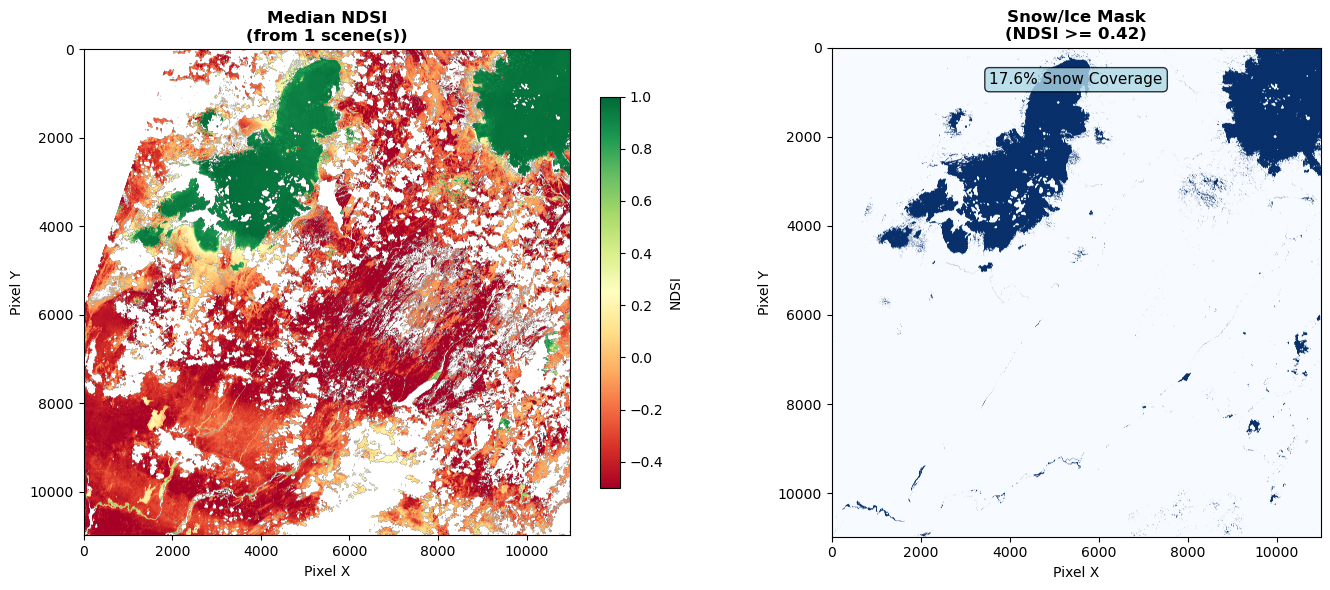


✓ Visualization complete
  Scenes processed: 1
  Snow coverage: 17.6%


In [6]:
# ======================================================================
# Visualization: NDSI and Snow/Ice Classification Results
# ======================================================================
# Creates a 2-panel diagnostic plot:
# 1. Median NDSI map (spectral snow index)
# 2. Binary snow/ice mask (pixels where NDSI >= threshold)

if composite:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # ----- Plot 1: Median NDSI -----
    ndsi_data = composite['ndsi_median'].values
    im1 = axes[0].imshow(ndsi_data, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[0].set_title(f'Median NDSI\n(from {composite["scene_count"]} scene(s))', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Pixel X')
    axes[0].set_ylabel('Pixel Y')
    plt.colorbar(im1, ax=axes[0], label='NDSI', shrink=0.8)
    
    # ----- Plot 2: Snow/Ice Mask -----
    snow_data = composite['snow_mask'].values.astype(float)
    im2 = axes[1].imshow(snow_data, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f'Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Pixel X')
    axes[1].set_ylabel('Pixel Y')
    
    # Add percentage annotation
    axes[1].text(0.5, 0.95, f'{composite["snow_percentage"]:.1f}% Snow Coverage', 
                 transform=axes[1].transAxes, ha='center', va='top', fontsize=11, 
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization complete")
    print(f"  Scenes processed: {composite['scene_count']}")
    print(f"  Snow coverage: {composite['snow_percentage']:.1f}%")
else:
    print("No composite available. Run stacking cell first.")

## RGB Visualization

This section loads RGB bands **independently** from the NDSI processing to avoid data interference.

**Why separate processing?**
- Keeps the NDSI data pipeline clean and unmodified
- RGB is only for visualization purposes
- Uses 60m resolution bands to minimize memory usage

**What this code does:**
- Loads B02 (Blue), B03 (Green), B04 (Red) at 60m resolution
- Builds a median RGB composite **without cloud masking** to keep full visual context
- Applies percentile stretching for better visualization

In [7]:
# ======================================================================
# RGB Processing - Separate from NDSI
# ======================================================================
# Loads RGB bands at 60m resolution to minimize memory/container load

def load_rgb_scene(href, x_slice, y_slice, use_full_scene=True):
    """
    Load RGB bands (B02, B03, B04) at 60m resolution for a single scene.
    Uses 60m bands for minimal data volume and container load.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, loads the entire scene extent instead of clipping to AOI.
    """
    scene_name = os.path.basename(href.rstrip("/"))
    
    # Load 60m RGB bands (lowest resolution = minimal data)
    ds_rgb = xr.open_zarr(href, group="/measurements/reflectance/r60m")[["b02", "b03", "b04"]]
    
    if use_full_scene:
        # Use full scene extent - no clipping
        print(f"  → Using full scene extent")
    else:
        # Clip to AOI
        ds_rgb = ds_rgb.sel(x=x_slice, y=y_slice)
    
    return ds_rgb


def create_rgb_composite(hrefs, x_slice, y_slice, use_full_scene=True):
    """
    Create median RGB composite from all scenes.
    No cloud mask is applied to keep true visual context.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, processes entire scene extent instead of clipping to AOI.
    """
    print(f"Loading RGB data from {len(hrefs)} scene(s)...")
    print(f"Mode: {'Full scene extent' if use_full_scene else 'Clipped to AOI'}")
    
    rgb_scenes = []
    for i, href in enumerate(hrefs):
        try:
            scene = load_rgb_scene(href, x_slice, y_slice, use_full_scene=use_full_scene)
            rgb_scenes.append(scene.compute())
            print(f"  [{i+1}/{len(hrefs)}] Loaded: {os.path.basename(href)}")
        except Exception as e:
            print(f"  [{i+1}/{len(hrefs)}] Error: {e}")
            continue
    
    if not rgb_scenes:
        return None
    
    if len(rgb_scenes) == 1:
        # Single scene
        rgb_median = xr.concat([
            rgb_scenes[0]["b04"],
            rgb_scenes[0]["b03"],
            rgb_scenes[0]["b02"],
        ], dim="band").assign_coords(band=["R", "G", "B"])
    else:
        # Stack and compute median
        r_stack = xr.concat([s["b04"] for s in rgb_scenes], dim="scene")
        g_stack = xr.concat([s["b03"] for s in rgb_scenes], dim="scene")
        b_stack = xr.concat([s["b02"] for s in rgb_scenes], dim="scene")
        
        rgb_median = xr.concat([
            r_stack.median(dim="scene", skipna=True),
            g_stack.median(dim="scene", skipna=True),
            b_stack.median(dim="scene", skipna=True),
        ], dim="band").assign_coords(band=["R", "G", "B"])
    
    print(f"✓ RGB composite created from {len(rgb_scenes)} scene(s)")
    return {"rgb_median": rgb_median, "scene_count": len(rgb_scenes)}


# Create RGB composite (independent from NDSI)
if hrefs:
    rgb_composite = create_rgb_composite(hrefs, x_slice, y_slice, use_full_scene=USE_FULL_SCENE)
else:
    rgb_composite = None
    print("No scenes available for RGB processing.")

Loading RGB data from 1 scene(s)...
Mode: Full scene extent
  → Using full scene extent
  [1/1] Loaded: S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr
✓ RGB composite created from 1 scene(s)


### RGB vs Snow Mask Comparison (60m)

Creates a side-by-side comparison:
1. **Median RGB Composite (60m)** - True color visualization of the scene(s) with 2-98% percentile stretch
2. **Snow/Ice Mask** - Binary classification overlaid for comparison with the visual appearance

RGB COMPOSITE (60m Resolution)
Creating RGB composite from 1 scene(s)...
Mode: Full scene extent
Loading RGB (60m): S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr
  → Using full scene extent
  [1/1] Loaded successfully
✓ RGB composite created


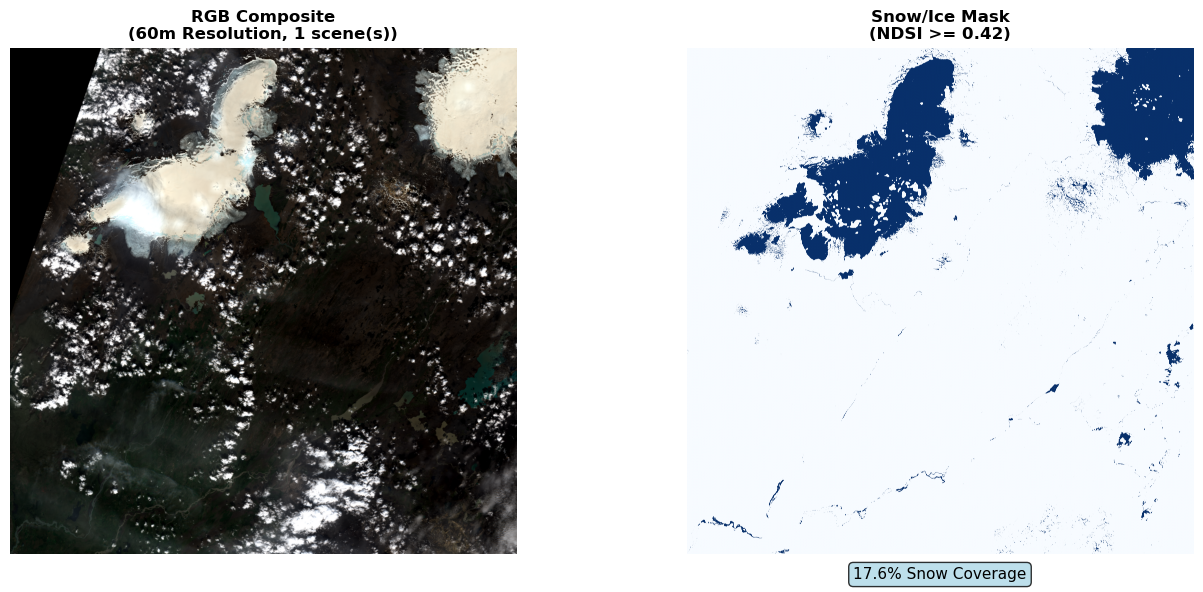


✓ Visualization complete
  Scenes processed: 1
  Snow coverage: 17.6%


In [8]:
# ======================================================================
# Visualization: RGB Composite vs Snow/Ice Mask (60m Resolution)
# ======================================================================
# Shows raw RGB without cloud masking for full visual context

def load_rgb_10m(href, x_slice, y_slice, use_full_scene=True):
    """
    Load RGB bands (B02, B03, B04) at 60m resolution.
    No cloud masking applied - shows full scene.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, loads the entire scene extent instead of clipping to AOI.
    """
    scene_name = os.path.basename(href.rstrip("/"))
    print(f"Loading RGB (60m): {scene_name}")
    
    # Load 60m RGB bands (B02=Blue, B03=Green, B04=Red)
    ds_10m = xr.open_zarr(href, group="/measurements/reflectance/r60m")[["b02", "b03", "b04"]]
    
    if use_full_scene:
        # Use full scene extent - no clipping
        print(f"  → Using full scene extent")
    else:
        # Clip to AOI
        ds_10m = ds_10m.sel(x=x_slice, y=y_slice)
    
    return ds_10m


def create_rgb_composite_10m(hrefs, x_slice, y_slice, use_full_scene=True):
    """
    Create RGB composite from all scenes at 60m resolution.
    No cloud masking - full visual context preserved.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, processes entire scene extent instead of clipping to AOI.
    """
    print(f"Creating RGB composite from {len(hrefs)} scene(s)...")
    print(f"Mode: {'Full scene extent' if use_full_scene else 'Clipped to AOI'}")
    
    rgb_scenes = []
    for i, href in enumerate(hrefs):
        try:
            ds_rgb = load_rgb_10m(href, x_slice, y_slice, use_full_scene=use_full_scene)
            ds_rgb = ds_rgb.compute()
            rgb_scenes.append(ds_rgb)
            print(f"  [{i+1}/{len(hrefs)}] Loaded successfully")
            
        except Exception as e:
            print(f"  [{i+1}/{len(hrefs)}] Error: {e}")
            continue
    
    if not rgb_scenes:
        return None
    
    # Stack RGB
    if len(rgb_scenes) == 1:
        rgb_median = xr.concat([
            rgb_scenes[0]["b04"],  # R
            rgb_scenes[0]["b03"],  # G
            rgb_scenes[0]["b02"],  # B
        ], dim="band").assign_coords(band=["R", "G", "B"])
    else:
        # Median across all scenes
        r_stack = xr.concat([s["b04"] for s in rgb_scenes], dim="scene")
        g_stack = xr.concat([s["b03"] for s in rgb_scenes], dim="scene")
        b_stack = xr.concat([s["b02"] for s in rgb_scenes], dim="scene")
        
        rgb_median = xr.concat([
            r_stack.median(dim="scene", skipna=True),
            g_stack.median(dim="scene", skipna=True),
            b_stack.median(dim="scene", skipna=True),
        ], dim="band").assign_coords(band=["R", "G", "B"])
    
    print(f"✓ RGB composite created")
    return {"rgb_median": rgb_median, "scene_count": len(rgb_scenes)}


# Create RGB composite (no cloud masking)
if hrefs:
    print("="*60)
    print("RGB COMPOSITE (60m Resolution)")
    print("="*60)
    rgb_full = create_rgb_composite_10m(hrefs, x_slice, y_slice, use_full_scene=USE_FULL_SCENE)
else:
    rgb_full = None
    print("No scenes available.")

# Visualization
if rgb_full and composite:
    rgb_da = rgb_full['rgb_median']
    r = rgb_da.sel(band="R").values
    g = rgb_da.sel(band="G").values
    b = rgb_da.sel(band="B").values
    
    # Stack RGB
    rgb_np = np.stack([r, g, b], axis=-1).astype("float32")
    
    # Normalize if needed (Sentinel-2 reflectance is often 0-10000)
    max_val = np.nanmax(rgb_np)
    if max_val > 1.5:
        rgb_np = rgb_np / 10000.0
    
    # Replace NaN with 0
    rgb_np = np.nan_to_num(rgb_np, nan=0.0)
    
    # Per-channel percentile stretching (2-98%) for better contrast
    rgb_stretched = np.zeros_like(rgb_np)
    for c in range(3):
        channel = rgb_np[..., c]
        valid = (channel > 0)
        if np.any(valid):
            low, high = np.percentile(channel[valid], [2, 98])
            stretched = (channel - low) / (high - low + 1e-6)
            rgb_stretched[..., c] = np.clip(stretched, 0, 1)
    
    # Gamma correction for better visualization
    gamma = 1.1
    rgb_stretched = np.power(rgb_stretched, 1 / gamma)
    
    # === PLOT ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # ----- Plot 1: RGB Composite -----
    axes[0].imshow(rgb_stretched)
    axes[0].set_title(f"RGB Composite\n(60m Resolution, {rgb_full['scene_count']} scene(s))", 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # ----- Plot 2: Snow/Ice Mask -----
    snow_data = composite['snow_mask'].values.astype(float)
    axes[1].imshow(snow_data, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f"Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})", 
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')
    axes[1].text(0.5, -0.05, f"{composite['snow_percentage']:.1f}% Snow Coverage",
                 transform=axes[1].transAxes, ha='center', fontsize=11,
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization complete")
    print(f"  Scenes processed: {rgb_full['scene_count']}")
    print(f"  Snow coverage: {composite['snow_percentage']:.1f}%")
else:
    print("RGB or NDSI composite missing.")

## Interactive Map: Scene Locations & Processed Area

This section creates an interactive map showing the spatial context of the analysis.

**Map Layers:**
- **Green polygon**: The actual processed composite area (data extent after spatial slicing)
- **Blue polygons**: Full Sentinel-2 scene extents from the STAC catalog
- **Red points**: Glacier seed locations used for the AOI definition
- **Orange dashed box**: Area of Interest (AOI) bounding box

**Features:**
- Esri satellite imagery basemap
- Layer control to toggle visibility of each layer
- Hover over polygons for scene details (ID, date, cloud cover)

In [10]:
# ======================================================================
# Interactive Map with Folium
# ======================================================================
# Shows scene bounding boxes on a satellite background
# Highlights the actual processed area (composite bbox) in green

import folium
from folium import GeoJson, FeatureGroup
from folium.plugins import Fullscreen

# Create GeoDataFrame with all scene bounding boxes (blue)
scene_bboxes = []
for item in valid_items:
    bbox = item.bbox  # [west, south, east, north]
    scene_polygon = box(bbox[0], bbox[1], bbox[2], bbox[3])
    scene_bboxes.append({
        "geometry": scene_polygon,
        "scene_id": item.id,
        "datetime": item.datetime.strftime("%Y-%m-%d %H:%M") if item.datetime else "N/A",
        "cloud_cover": item.properties.get("eo:cloud_cover", "N/A")
    })

scenes_gdf = gpd.GeoDataFrame(scene_bboxes, crs="EPSG:4326")

# === Get Composite BBox (actual processed area) ===
composite_gdf = None
if 'composite' in dir() and composite is not None:
    # Extract coordinates from composite (in UTM)
    try:
        x_coords = composite['ndsi_median'].coords['x'].values
        y_coords = composite['ndsi_median'].coords['y'].values
        
        # Get bounds in UTM
        utm_west = float(x_coords.min())
        utm_east = float(x_coords.max())
        utm_south = float(y_coords.min())
        utm_north = float(y_coords.max())
        
        # Transform back to WGS84
        transformer_to_wgs84 = Transformer.from_crs(target_crs, "EPSG:4326", always_xy=True)
        
        # Transform all 4 corners to handle projection distortion
        sw_lon, sw_lat = transformer_to_wgs84.transform(utm_west, utm_south)
        se_lon, se_lat = transformer_to_wgs84.transform(utm_east, utm_south)
        ne_lon, ne_lat = transformer_to_wgs84.transform(utm_east, utm_north)
        nw_lon, nw_lat = transformer_to_wgs84.transform(utm_west, utm_north)
        
        # Create polygon from corners
        from shapely.geometry import Polygon
        composite_polygon = Polygon([
            (sw_lon, sw_lat),
            (se_lon, se_lat),
            (ne_lon, ne_lat),
            (nw_lon, nw_lat),
            (sw_lon, sw_lat)  # close the ring
        ])
        
        composite_gdf = gpd.GeoDataFrame([{
            "geometry": composite_polygon,
            "name": "Processed Composite Area",
            "scene_count": composite.get("scene_count", 1),
            "snow_coverage": f"{composite.get('snow_percentage', 0):.1f}%"
        }], crs="EPSG:4326")
        
        print(f"Composite bbox (UTM): W={utm_west:.0f}, E={utm_east:.0f}, S={utm_south:.0f}, N={utm_north:.0f}")
        print(f"Composite bbox (WGS84): W={sw_lon:.4f}, E={ne_lon:.4f}, S={sw_lat:.4f}, N={ne_lat:.4f}")
    except Exception as e:
        print(f"Could not extract composite bbox: {e}")

# Calculate map center
if composite_gdf is not None:
    minx, miny, maxx, maxy = composite_gdf.total_bounds
    center_lon = (minx + maxx) / 2
    center_lat = (miny + maxy) / 2
else:
    center_lon = (bbox_4326[0] + bbox_4326[2]) / 2
    center_lat = (bbox_4326[1] + bbox_4326[3]) / 2

# Create map with Esri satellite tiles
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=7,
    tiles=None
)

# Add Esri World Imagery as satellite basemap
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri, Maxar, Earthstar Geographics",
    name="Satellite",
    overlay=False
).add_to(m)

# === Layer 1: All Sentinel-2 Scenes (Blue) ===
scenes_layer = FeatureGroup(name="All Sentinel-2 Scenes")
GeoJson(
    scenes_gdf.__geo_interface__,
    style_function=lambda x: {
        "fillColor": "#3388ff",
        "color": "#3388ff",
        "weight": 2,
        "fillOpacity": 0.15
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["scene_id", "datetime", "cloud_cover"],
        aliases=["Scene ID:", "Date:", "Cloud Cover:"],
        localize=True
    )
).add_to(scenes_layer)
scenes_layer.add_to(m)

# === Layer 2: Composite Processed Area (Green) ===
if composite_gdf is not None:
    composite_layer = FeatureGroup(name="PROCESSED AREA (Composite)")
    GeoJson(
        composite_gdf.__geo_interface__,
        style_function=lambda x: {
            "fillColor": "#00ff00",
            "color": "#00ff00",
            "weight": 5,
            "fillOpacity": 0.25
        },
        tooltip=folium.GeoJsonTooltip(
            fields=["name", "scene_count", "snow_coverage"],
            aliases=["Area:", "Scenes:", "Snow:"],
            localize=True
        )
    ).add_to(composite_layer)
    composite_layer.add_to(m)

# === Layer 3: Seed Points (Red) ===
seeds_layer = FeatureGroup(name="Glacier Seed Points")
for idx, row in seeds_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="#ffffff",
        fill=True,
        fillColor="#ff0000",
        fillOpacity=1.0,
        weight=1
    ).add_to(seeds_layer)
seeds_layer.add_to(m)

# === Layer 4: AOI Bounding Box (Orange) ===
aoi_polygon = box(bbox_4326[0], bbox_4326[1], bbox_4326[2], bbox_4326[3])
aoi_gdf = gpd.GeoDataFrame([{"geometry": aoi_polygon, "name": "AOI"}], crs="EPSG:4326")

aoi_layer = FeatureGroup(name="Area of Interest (AOI)")
GeoJson(
    aoi_gdf.__geo_interface__,
    style_function=lambda x: {
        "fillColor": "transparent",
        "color": "#ff6600",
        "weight": 3,
        "dashArray": "10, 5"
    }
).add_to(aoi_layer)
aoi_layer.add_to(m)

# Add layer control and fullscreen button
folium.LayerControl(collapsed=False).add_to(m)
Fullscreen().add_to(m)

# Print legend
print(f"\n{'='*50}")
print(f"Map Legend:")
if composite_gdf is not None:
    print(f"   Green polygon: Actual processed composite area")
    print(f"    (This is the data extent after spatial slicing)")
print(f"  • Blue polygons: Full Sentinel-2 scene extents ({len(scenes_gdf)})")
print(f"  • Red points: Glacier seed locations ({len(seeds_gdf)})")
print(f"  • Orange dashed: Area of Interest (AOI)")
print(f"{'='*50}")

m

Composite bbox (UTM): W=499985, E=609775, S=7090205, N=7199995
Composite bbox (WGS84): W=-21.0003, E=-18.6799, S=63.9389, N=64.9060

Map Legend:
   Green polygon: Actual processed composite area
    (This is the data extent after spatial slicing)
  • Blue polygons: Full Sentinel-2 scene extents (107)
  • Red points: Glacier seed locations (21)
  • Orange dashed: Area of Interest (AOI)
